<a href="https://colab.research.google.com/github/michaeledge27/mathModeling/blob/main/notebooks/shufflingUnderConstraints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# Define the cards
clubs = ['club 2', 'club 3', 'club 4', 'club 5', 'club 6']
diamonds = ['diamond 2', 'diamond 3', 'diamond 4', 'diamond 5', 'diamond 6']
hearts = ['heart 2', 'heart 3', 'heart 4', 'heart 5', 'heart 6']
spades = ['spade 2', 'spade 3', 'spade 4']

In [3]:
all_cards = clubs + diamonds + hearts + spades

In [4]:
# Define constraints
club_spade_positions = [0, 3, 6, 9, 12]      # No clubs or spades
heart_positions = [1, 4, 7, 10, 13]          # No hearts
diamond_spade_positions = [2, 5, 8, 11, 14]  # No diamonds or spades

In [5]:
# Function to check if an allocation is legal
def is_legal_allocation(positions):
    for i in club_spade_positions:
        if 'club' in positions[i] or 'spade' in positions[i]:
            return False
    for i in heart_positions:
        if 'heart' in positions[i]:
            return False
    for i in diamond_spade_positions:
        if 'diamond' in positions[i] or 'spade' in positions[i]:
            return False
    return True

In [6]:
# Start with a random legal allocation
def initial_legal_allocation():
    random.shuffle(clubs)
    random.shuffle(diamonds)
    random.shuffle(hearts)
    random.shuffle(spades)

    positions = [None] * 15
    for pos in club_spade_positions:
        positions[pos] = clubs.pop() if clubs else spades.pop()
    for pos in heart_positions:
        positions[pos] = hearts.pop()
    for pos in diamond_spade_positions:
        positions[pos] = diamonds.pop() if diamonds else spades.pop()
    return positions

In [7]:
# Perform the Markov chain step
def markov_chain_step(positions):
    indices = random.sample(range(15), 3)  # Choose three random positions
    cards = [positions[i] for i in indices]

    # Attempt different swaps (A <-> B, A <-> C, B <-> C, etc.)
    swap_options = [
        (0, 1), (0, 2), (1, 2),  # Pairwise swaps
        (0, 1, 2), (0, 2, 1)     # Cyclic swaps (A->B->C, A->C->B)
    ]
    random.shuffle(swap_options)  # Randomize the order of the swaps

    original_positions = positions[:]  # Keep a copy of the original allocation

    # Try each swap option
    for option in swap_options:
        new_positions = positions[:]
        if len(option) == 2:  # Simple swap
            new_positions[indices[option[0]]], new_positions[indices[option[1]]] = cards[option[1]], cards[option[0]]
        else:  # Cyclic swap
            new_positions[indices[option[0]]], new_positions[indices[option[1]]], new_positions[indices[option[2]]] = cards[option[1]], cards[option[2]], cards[option[0]]

        # Check if the new allocation is legal
        if is_legal_allocation(new_positions):
            return new_positions  # Accept the new allocation if it's legal

    return original_positions  # If no valid swaps, return the original allocation

In [8]:
# Run the Markov chain simulation and collect position frequencies
def markov_chain_simulation(iterations):
    positions = initial_legal_allocation()  # Start with a legal allocation
    position_counts = defaultdict(lambda: [0] * 15)  # Track position counts for each card

    for _ in range(iterations):
        positions = markov_chain_step(positions)
        for i, card in enumerate(positions):
            position_counts[card][i] += 1  # Count the position of each card

    # Normalize counts to get the invariant distribution
    invariant_distribution = {card: [count / iterations for count in counts] for card, counts in position_counts.items()}

    return invariant_distribution


In [9]:
# Run the simulation for a large number of iterations
iterations = 10000  # Increase to improve accuracy
invariant_distribution = markov_chain_simulation(iterations)

In [10]:
# Convert to DataFrame for heatmap
distribution_df = pd.DataFrame(invariant_distribution).T
distribution_df.columns = [f'Position {i+1}' for i in range(15)]

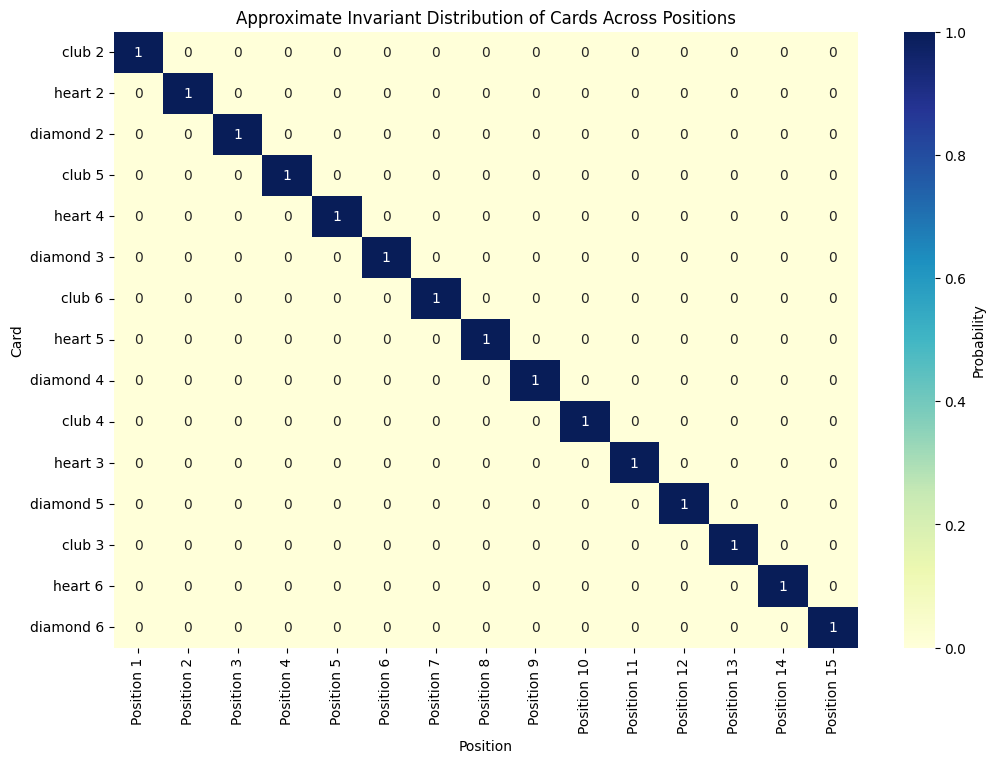

In [11]:
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(distribution_df, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Probability'})
plt.title("Approximate Invariant Distribution of Cards Across Positions")
plt.xlabel("Position")
plt.ylabel("Card")
plt.show()